In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time


import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
input_data = '../MSc Student Data 2021/aluminium - month/aluminium_inputs.csv'
target_data = '../MSc Student Data 2021/aluminium - month/aluminium_target.csv'

In [18]:
f = []
for (dirpath, dirnames, filenames) in os.walk('../MSc Student Data 2021/aluminium - month'):
    f.extend(filenames)
    print(f)
    break

['aluminium_target.csv', 'aluminium_inputs.csv']


In [19]:
input_df = pd.read_csv(input_data)
target_df = pd.read_csv(target_data)

In [20]:
dates = input_df['date'].values

In [21]:
target_df[['y']] = StandardScaler().fit_transform(target_df[['y']])

In [22]:
#target_df['log return'] = np.log(target_df['y']).diff()

In [23]:
input_df[['cot_positions_0', 'cot_positions_1', 'cta_0', 'cta_1',
       'curve_0', 'curve_1', 'curve_2', 'export_currency_0',
       'export_currency_1', 'export_currency_2', 'export_currency_3',
       'export_currency_4', 'export_currency_5', 'export_currency_6',
       'export_currency_7', 'export_currency_8', 'freight_export_port_0',
       'freight_export_port_1', 'freight_export_port_2',
       'freight_export_port_3', 'freight_export_port_4',
       'freight_export_port_5', 'freight_export_port_6',
       'freight_export_port_7', 'freight_export_port_8',
       'freight_export_port_9', 'inventory_0', 'inventory_1', 'inventory_2',
       'inventory_3', 'inventory_4', 'inventory_5', 'satellite_0',
       'satellite_1', 'satellite_2', 'satellite_3', 'satellite_4',
       'satellite_5', 'satellite_6', 'satellite_7', 'satellite_8',
       'satellite_9', 'satellite_10', 'satellite_11', 'seasonality_0',
       'sentiment_0', 'sentiment_1', 'sentiment_2', 'sentiment_3',
       'sentiment_4', 'sentiment_5', 'sentiment_6', 'sentiment_7',
       'sentiment_8', 'sentiment_9', 'technical_0']] = StandardScaler().fit_transform(input_df[['cot_positions_0', 'cot_positions_1', 'cta_0', 'cta_1',
       'curve_0', 'curve_1', 'curve_2', 'export_currency_0',
       'export_currency_1', 'export_currency_2', 'export_currency_3',
       'export_currency_4', 'export_currency_5', 'export_currency_6',
       'export_currency_7', 'export_currency_8', 'freight_export_port_0',
       'freight_export_port_1', 'freight_export_port_2',
       'freight_export_port_3', 'freight_export_port_4',
       'freight_export_port_5', 'freight_export_port_6',
       'freight_export_port_7', 'freight_export_port_8',
       'freight_export_port_9', 'inventory_0', 'inventory_1', 'inventory_2',
       'inventory_3', 'inventory_4', 'inventory_5', 'satellite_0',
       'satellite_1', 'satellite_2', 'satellite_3', 'satellite_4',
       'satellite_5', 'satellite_6', 'satellite_7', 'satellite_8',
       'satellite_9', 'satellite_10', 'satellite_11', 'seasonality_0',
       'sentiment_0', 'sentiment_1', 'sentiment_2', 'sentiment_3',
       'sentiment_4', 'sentiment_5', 'sentiment_6', 'sentiment_7',
       'sentiment_8', 'sentiment_9', 'technical_0']])

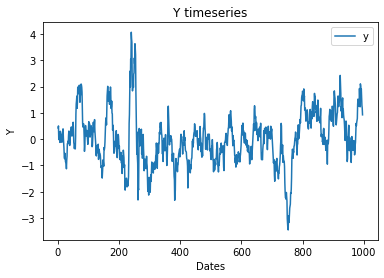

In [24]:
y = target_df['y'].values
index = [i+1 for i in range(len(y))]

plt.plot(index, y ,label = "y")
plt.xlabel('Dates')
plt.ylabel('Y')
plt.title('Y timeseries')
plt.legend()
plt.show()
print()

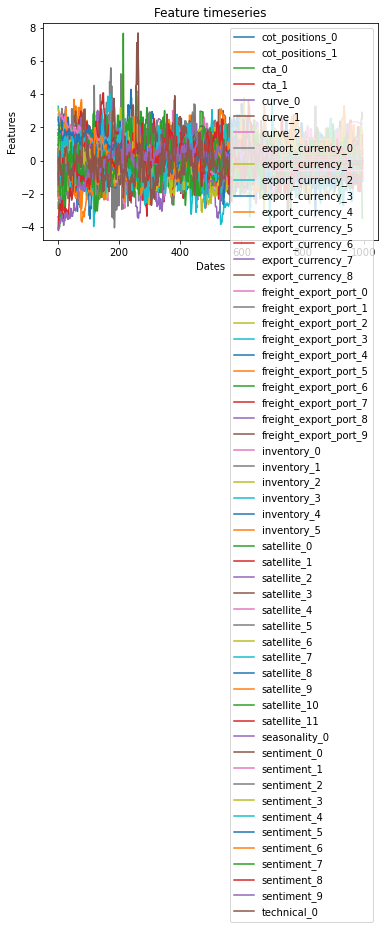

In [25]:
features = []
for col in input_df.columns:
    features.append(input_df[col].values)
    
index = [i+1 for i in range(len(y))]

for i, col in enumerate(input_df.columns):
    if(i!=0):
        plt.plot(index, features[i] ,label = col)
    
plt.xlabel('Dates')
plt.ylabel('Features')
plt.title('Feature timeseries')
plt.legend()
plt.show()
print()

In [26]:
def convert_log_return(labels):
    l = []
    for count, value in enumerate(labels):
        if(count!=len(labels)-1):
            
            if(labels[count] == 0):
                labels[count] += 0.00001
            if(labels[count + 1] == 0):
                l.append(np.log(0.00001))
            else:
                l.append(np.log((labels[count + 1])/(labels[count])))
    return l

In [27]:
inputs = np.array(features[1:]).transpose()
labels = np.array(y)

In [29]:
inp,lbl = utils.split_timeseries(1,22-2,inputs,labels)
print(inp.shape)
print(lbl.shape)
inp = np.reshape(inp, (inp.shape[0],inp.shape[1]*inp.shape[2]))
print(inp.shape)


(975, 1, 56)
(975,)
(975, 56)


In [30]:
train_batches,test_batches = utils.train_test_split(inp,lbl,dates,100,0.80)

In [31]:
print(len(train_batches))
print(len(test_batches))
train_data,train_labels,train_dates = train_batches[0]
test_data,test_labels,test_dates = test_batches[0]

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(len(train_dates))
print(len(test_dates))

44
44
(80, 56)
(80,)
(20, 56)
(20,)
80
20


In [32]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [33]:
losses = []
predictions = []

for i,train_batch in enumerate(train_batches):
    
    print("Training batch " + str(i) + "/" + str(len(train_batches)))
    train_data,train_labels,dates = train_batch
    test_data,test_labels,dates = test_batches[i]
    print("Dates: " + dates[0] + " " + dates[-1])
    clear_output(wait=True)

    
    train_data = torch.from_numpy(train_data)
    train_labels = torch.from_numpy(train_labels)
    test_data = torch.from_numpy(test_data)
    test_labels = torch.from_numpy(test_labels)


    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_data, train_labels, likelihood)
    
    model.double()
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 150

    for j in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_data)
        # Calc loss and backprop gradients
        loss = -mll(output, train_labels)
        loss.backward()
        '''print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))'''
        losses.append(loss)
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_data))
        predictions.append(observed_pred)
        
    #time.sleep(5)

Training batch 43/44
Dates: 2020-11-24 2020-12-21


In [34]:
print(mmda/len(train_batches))

0.514354066985646


In [39]:
### get the predictions
mean_preds = []
lower = []
upper = []


for pred in predictions:
        mean_preds.append(pred.mean.numpy())
        l, u = pred.confidence_region()
        lower.append(l.numpy())
        upper.append(u.numpy())
        
mean_preds = np.array(mean_preds).flatten()
lower = np.array(lower).flatten()
upper = np.array(upper).flatten()

In [ ]:
index = [i+1 for i in range(mean_preds.shape[0])]

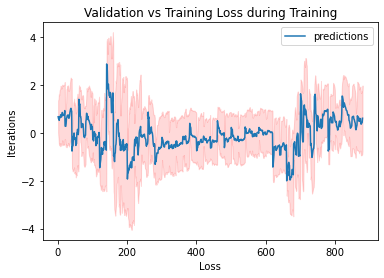

In [45]:
fig, ax = plt.subplots()
ax.plot(index,mean_preds,label = 'predictions')
ax.fill_between(index, lower, upper, color='r', alpha=.15)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [46]:
test_labels = []
for i,test_batch in enumerate(test_batches):
    _,l,_ = test_batch
    test_labels.append(l)
test_labels = np.array(test_labels).flatten()

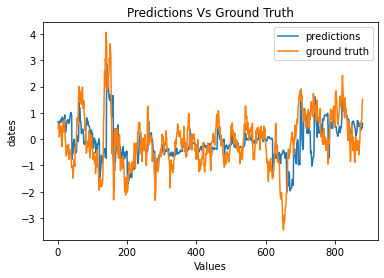

In [47]:
plt.plot(index, mean_preds ,label = "predictions")
plt.plot(index, test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [50]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(test_labels,mean_preds)))
print("Root Mean Squared Error : " + str(utils.rmse(mean_preds, test_labels)))
print("Mean Absolute Percentage Error: " + str(utils.mean_absolute_percentage_error(test_labels,mean_preds)))

Mean Directional Accuracy: 0.515358361774744
Root Mean Squared Error : 0.8660820437339165
Mean Absolute Percentage Error: 319.73681173177914
